In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
import seaborn as sns
cm = sns.color_palette(as_cmap=True)

## Simulation notes
For the simulation, the time is following this convention:
1 time unit = 10 ms


In [2]:
def epileptor(q, parameters):

	x1,y1,z,x2,y2,g = q
	a1, b1, c1, d1, tau, a2, c2, m, x0, r, s, Irest1, Irest2, Is1, Is2 =\
    parameters['a1'], parameters['b1'], parameters['c1'], parameters['d1'], parameters['tau'], \
    parameters['a2'], parameters['c2'], parameters['m'], parameters['x0'], parameters['r'], \
    parameters['s'], parameters['Irest1'], parameters['Irest2'], parameters['Is1'], parameters['Is2']
    
    ###################  Population 1 #################
	if x1 < 0:
		dx1 = y1  - a1 * (x1)**3  + b1 * (x1)**2 - z + Irest1 + Is1
	else:
		dx1 = y1 + (m -x2 + 0.6 * (z-4)**2)*x1- z + Irest1 + Is1
	dy1 = c1 - d1 * (x1)**2 - y1

	################## Population 2 ################### 
	dx2 = -y2 + x2 - (x2)**3 + Irest2 + 2*g - c2*(z-3.5) + Is2
	if x2 < -0.25:
		dy2 = 1./tau * (-y2)
	else:
		dy2 = 1./tau * (-y2 + a2 * (x2 + 0.25 ))
	dg = -0.01 * (g - 0.1*x1);

	################### Energy #####################"
	dz = r* (s * (x1 - x0) -z)
	#pdb.set_trace()
	return np.hstack((dx1, dy1, dz, dx2, dy2, dg))


# Parameters
parameters = {'a1':1, 'b1':3, 'c1':1, 'd1':5,
              'tau':10, 'a2':6, 'c2':0.3, 'm':0,
              'x0':-2.05, 'r':0.00005, 's':4,
              'Irest1':3.1, 'Irest2':0.45, 'Is1':0, 'Is2':0}

# Find initial conditions by root solving
# q0 = [-1.37, -8.39,  2.92, -0.71,  0.  , -0.14]
# q = fsolve(epileptor, q0, args=parameters)
q = [-1.99614571e+00, -1.89239518e+01,  4.01429731e+00, -1.04666606e+00, 5.01660123e-21, -1.97834221e-01]

# sim parameters
dt = 0.001
t_sim_init = 200
n_samples_init = int(t_sim_init/dt)
t_sim = 20000
n_samples = int(t_sim/dt)
upsamp = 10
t = np.linspace(0, t_sim, t_sim*upsamp)

# stim parameters
t_start = 1
I_duration = .3
I_inter = 1000-I_duration
n_stim = 30
Is1 = 2
Is2 = 5

stim = 1
parameters['Is1'] = 0
parameters['Is2'] = 0
for it in range(n_samples_init):
    # Runge-Kutta scheme
    p1 = epileptor(q, parameters)
    p2 = epileptor(q+(dt/2)*p1, parameters)
    p3 = epileptor(q+(dt/2)*p2, parameters)
    p4 = epileptor(q+(dt/2)*p3, parameters)
    q += dt/6 * (p1+2*p2+2*p3+p4)

lq = []
for it in range(n_samples):
    # if it%10000==0:
    #     print(it)
    tc = it*dt
    if q[0]>-.5 and stim:
        stim = 0 # no stim after a seizure
        te = tc*upsamp
        
    tstim = 0
    if stim:
        for i_stim in range(n_stim):
            if tc>=t_start + i_stim*I_duration + i_stim*I_inter and tc<t_start + (i_stim+1)*I_duration + i_stim*I_inter:
                tstim = 1
    if tstim:
        parameters['Is1'] = Is1
        parameters['Is2'] = Is2
    else:
        parameters['Is1'] = 0
        parameters['Is2'] = 0

    # Runge-Kutta scheme
    p1 = epileptor(q, parameters)
    p2 = epileptor(q+(dt/2)*p1, parameters)
    p3 = epileptor(q+(dt/2)*p2, parameters)
    p4 = epileptor(q+(dt/2)*p3, parameters)
    q += dt/6 * (p1+2*p2+2*p3+p4)

    if it%int(1/(upsamp*dt))==0:
        lq.append(q.copy())
lq = np.array(lq)

### Time series

In [3]:
lq.shape

(200000, 6)

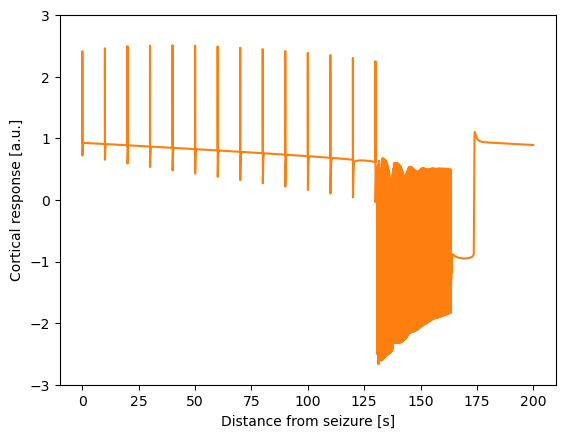

In [8]:
ts = -lq[:, 0] + lq[:, 3]
plt.figure()
plt.plot(t/100, ts, color=cm[1])
# plt.xlim([-5, 60])
plt.ylim([-3, 3])
plt.xlabel('Distance from seizure [s]')
plt.ylabel('Cortical response [a.u.]')
plt.savefig('figures/single_stim_diff_time_time_series.svg')

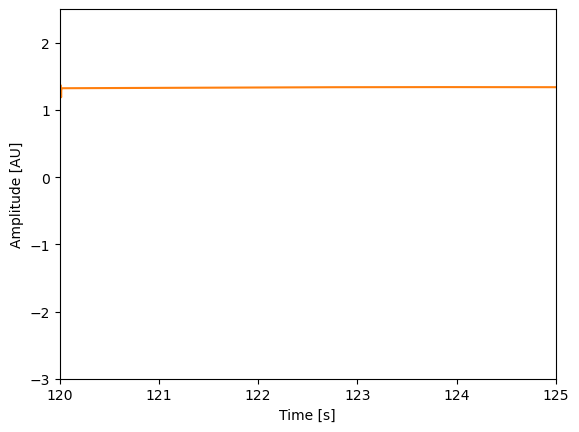

In [5]:
ts = -lq[:, 0] #+ lq[:, 3]
plt.figure()
plt.plot(t/100, ts, color=cm[1])
plt.xlim([120, 125])
plt.ylim([-3, 2.5])
plt.xlabel('Time [s]')
plt.ylabel('Amplitude [AU]')
plt.savefig('figures/single_stim_diff_time_time_series_zoom.svg')

## Baseline

In [6]:
def epileptor(q, parameters):

	x1,y1,z,x2,y2,g = q
	a1, b1, c1, d1, tau, a2, c2, m, x0, r, s, Irest1, Irest2, Is1, Is2 =\
    parameters['a1'], parameters['b1'], parameters['c1'], parameters['d1'], parameters['tau'], \
    parameters['a2'], parameters['c2'], parameters['m'], parameters['x0'], parameters['r'], \
    parameters['s'], parameters['Irest1'], parameters['Irest2'], parameters['Is1'], parameters['Is2']
    
    ###################  Population 1 #################
	if x1 < 0:
		dx1 = y1  - a1 * (x1)**3  + b1 * (x1)**2 - z + Irest1 + Is1
	else:
		dx1 = y1 + (m -x2 + 0.6 * (z-4)**2)*x1- z + Irest1 + Is1
	dy1 = c1 - d1 * (x1)**2 - y1

	################## Population 2 ################### 
	dx2 = -y2 + x2 - (x2)**3 + Irest2 + 2*g - c2*(z-3.5) + Is2
	if x2 < -0.25:
		dy2 = 1./tau * (-y2)
	else:
		dy2 = 1./tau * (-y2 + a2 * (x2 + 0.25 ))
	dg = -0.01 * (g - 0.1*x1);

	################### Energy #####################"
	dz = r* (s * (x1 - x0) -z)
	#pdb.set_trace()
	return np.hstack((dx1, dy1, dz, dx2, dy2, dg))


# Parameters
parameters = {'a1':1, 'b1':3, 'c1':1, 'd1':5,
              'tau':10, 'a2':6, 'c2':0.3, 'm':0,
              'x0':-2.2, 'r':0.00005, 's':4,
              'Irest1':3.1, 'Irest2':0.45, 'Is1':0, 'Is2':0}

# Find initial conditions by root solving
# q0 = [-1.37, -8.39,  2.92, -0.71,  0.  , -0.14]
# q = fsolve(epileptor, q0, args=parameters)
q = [-1.99614571e+00, -1.89239518e+01,  4.01429731e+00, -1.04666606e+00, 5.01660123e-21, -1.97834221e-01]

# sim parameters
dt = 0.001
t_sim_init = 200
n_samples_init = int(t_sim_init/dt)
t_sim = 20000
n_samples = int(t_sim/dt)
upsamp = 10
t = np.linspace(0, t_sim, t_sim*upsamp)

# stim parameters
t_start = 1
I_duration = .3
I_inter = 1000 - I_duration
n_stim = 30
Is1 = 2
Is2 = 5

stim = 1
parameters['Is1'] = 0
parameters['Is2'] = 0
for it in range(n_samples_init):
    # Runge-Kutta scheme
    p1 = epileptor(q, parameters)
    p2 = epileptor(q+(dt/2)*p1, parameters)
    p3 = epileptor(q+(dt/2)*p2, parameters)
    p4 = epileptor(q+(dt/2)*p3, parameters)
    q += dt/6 * (p1+2*p2+2*p3+p4)

lqb = []
for it in range(n_samples):
    # if it%10000==0:
    #     print(it)
    tc = it*dt
    if q[0]>-.5 and stim:
        stim = 0 # no stim after a seizure
        te = tc*upsamp
        
    tstim = 0
    if stim:
        for i_stim in range(n_stim):
            if tc>=t_start + i_stim*I_duration + i_stim*I_inter and tc<t_start + (i_stim+1)*I_duration + i_stim*I_inter:
                tstim = 1
    if tstim:
        parameters['Is1'] = Is1
        parameters['Is2'] = Is2
    else:
        parameters['Is1'] = 0
        parameters['Is2'] = 0

    # Runge-Kutta scheme
    p1 = epileptor(q, parameters)
    p2 = epileptor(q+(dt/2)*p1, parameters)
    p3 = epileptor(q+(dt/2)*p2, parameters)
    p4 = epileptor(q+(dt/2)*p3, parameters)
    q += dt/6 * (p1+2*p2+2*p3+p4)

    if it%int(1/(upsamp*dt))==0:
        lqb.append(q.copy())
lqb = np.array(lqb)

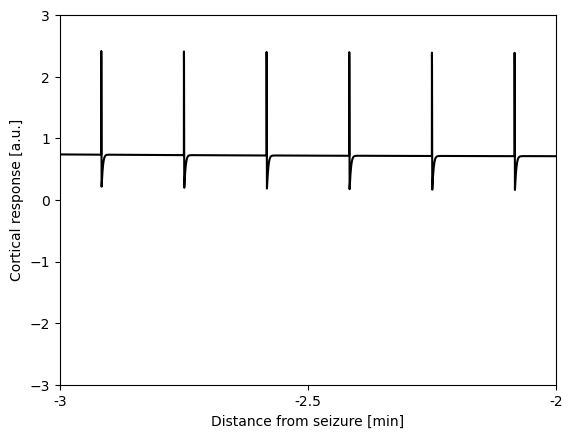

In [9]:
tsb = -lqb[:, 0] + lqb[:, 3]
plt.figure()
plt.plot(t/100, tsb, 'k')
plt.xticks([135, 165, 195], [-3, -2.5, -2])
plt.xlim([135, 195])
plt.ylim([-3, 3])
plt.xlabel('Distance from seizure [min]')
plt.ylabel('Cortical response [a.u.]')
plt.savefig('figures/single_stim_diff_time_time_series.svg')

### LL as a function of stimulation time and distance to bifurcation

130.615


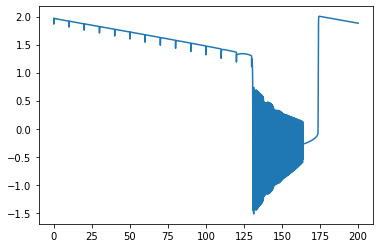

In [10]:
# first need to find when cross bifurcation in pop 1
ts = -lq[:, 0]
plt.plot(t/100, ts)
# plt.xlim([1.5, 2.])
xth = 1
print(np.nonzero(ts<xth)[0][0]/(100*upsamp))

[10.0, 10010.0, 20010.0, 30010.000000000004, 40010.0, 50010.0, 60010.00000000001, 70010.00000000001, 80010.0, 90010.00000000001, 100010.0, 110010.0, 120010.00000000001, 130010.0]
130.615


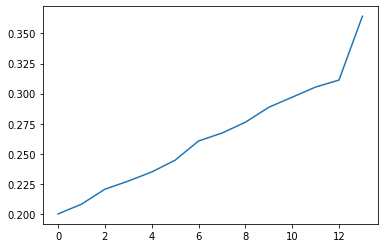

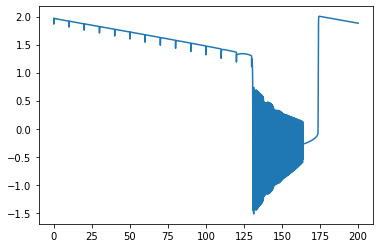

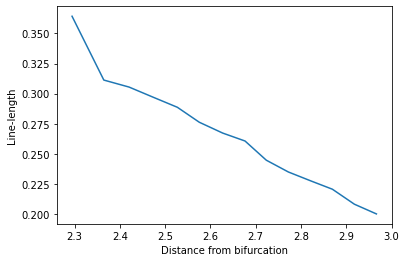

In [15]:
t_stim_onsets= []
for i_stim in range(n_stim):
    tc = (t_start + i_stim*I_duration + i_stim*I_inter)*upsamp
    if tc<te:
        t_stim_onsets.append(tc)
print(t_stim_onsets)

dif = []
for i_stim in range(len(t_stim_onsets)):
    dif.append(np.sum(np.abs(np.diff(ts[int(t_stim_onsets[i_stim]):int(t_stim_onsets[i_stim]+25*upsamp)]))))

plt.figure()
plt.plot(dif)
plt.savefig('figures/slow_train_stim_diff_exc_LL_vs_stim_time.svg')

# first find bifurcation point in x1 visually
ts = -lq[:, 0]
plt.figure()
plt.plot(t/100, ts)
x1th = 1
print(np.nonzero(ts<x1th)[0][0]/(100*upsamp))

dist_bif = []
for i_stim in range(len(t_stim_onsets)):
    dist_bif.append(np.linalg.norm(lq[int(t_stim_onsets[i_stim]), 0] - x1th))

plt.figure()
plt.plot(dist_bif, dif)
plt.xlabel('Distance from bifurcation')
plt.ylabel('Line-length')
plt.savefig('figures/slow_train_stim_diff_exc_LL_vs_dist_bif.svg')